In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/Project/'
%pwd

Mounted at /content/drive
[Errno 2] No such file or directory: '/content/drive/Othercomputers/My MacBook Air/SEM 1/682/Project/'
/content


'/content'

In [ ]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.7.0


In [ ]:
tf.random.set_seed(682)
np.random.seed(682)

In [ ]:
BATCH_SIZE = 64
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
#Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# utility to display a row of digits with their predictions
def display_images(digits, predictions, labels, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((n,))
  n_labels = labels[indexes]
 
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    class_index = n_predictions[i]
    
    plt.xlabel(classes[class_index])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(n_digits[i])

# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

In [ ]:
(training_images, training_labels) , (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 3s 0us/step


In [ ]:
print(training_images.shape)
print(validation_images.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


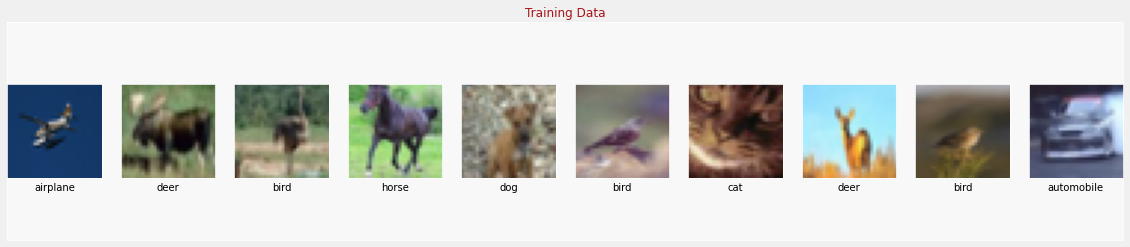

In [ ]:
display_images(training_images, training_labels, training_labels, "Training Data" )

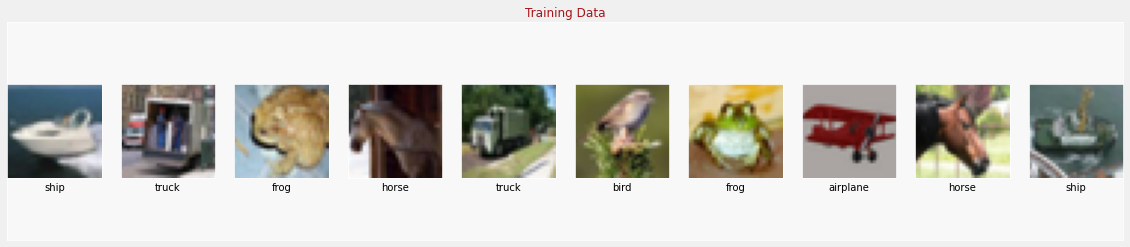

In [ ]:
display_images(validation_images, validation_labels, validation_labels, "Training Data" )

In [ ]:
def preprocess_image_input(input_images):
  input_images = tf.cast(input_images, 'float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims

In [ ]:
class Preprocess(tf.keras.layers.Layer):
    def __init__(self):
        super(Preprocess, self).__init__()

    def call(self, inputs):
        return preprocess_image_input(inputs)

In [ ]:
'''
Feature Extraction is performed by ResNet50 pretrained on imagenet weights. 
Input size is 224 x 224.
'''
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor


'''
Defines final dense layers and subsequent softmax layer for classification.
'''
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

'''
Since input image size is (32 x 32), first upsample the image by factor of (7x7) to transform it to (224 x 224)
Connect the feature extraction and "classifier" layers to build the model.
'''
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)
    pre_process = Preprocess()(resize)
    resnet_feature_extractor = feature_extractor(pre_process)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

'''
Define the model and compile it. 
Use Stochastic Gradient Descent as the optimizer.
Use Sparse Categorical CrossEntropy as the loss function.
'''
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model

model = define_compile_model()

model.summary()


94781440/94765736 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 preprocess (Preprocess)     (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                              

In [ ]:
!pip install wandb


In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
from wandb.keras import WandbCallback

wandb.init(project="my-test-project", entity="spalao")

wandb: Currently logged in as: spalao (use `wandb login --relogin` to force relogin)


In [ ]:
wandb.config = {
  "epochs": 5,
  "batch_size": 64
}

In [ ]:
EPOCHS = 5
history = model.fit(training_images, training_labels, epochs=EPOCHS, validation_data = (validation_images, validation_labels), batch_size=64, callbacks=[WandbCallback()])

Epoch 1/5
782/782 [==============================] - ETA: 0s - loss: 0.4004 - accuracy: 0.8667

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


782/782 [==============================] - 274s 335ms/step - loss: 0.4004 - accuracy: 0.8667 - val_loss: 0.2320 - val_accuracy: 0.9192
Epoch 2/5
782/782 [==============================] - 267s 341ms/step - loss: 0.1023 - accuracy: 0.9667 - val_loss: 0.2204 - val_accuracy: 0.9265
Epoch 3/5
782/782 [==============================] - 260s 333ms/step - loss: 0.0335 - accuracy: 0.9909 - val_loss: 0.1588 - val_accuracy: 0.9515
Epoch 4/5
782/782 [==============================] - 260s 332ms/step - loss: 0.0137 - accuracy: 0.9968 - val_loss: 0.1767 - val_accuracy: 0.9503
Epoch 5/5
782/782 [==============================] - 260s 332ms/step - loss: 0.0074 - accuracy: 0.9985 - val_loss: 0.1724 - val_accuracy: 0.9525


In [ ]:
model.save('saved_models/resnet50cifarwandb')

INFO:tensorflow:Assets written to: saved_models/resnet50cifarwandb/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
saved_model = tf.keras.models.load_model('saved_models/resnet50cifarwandb')
loss, accuracy = saved_model.evaluate(validation_images, validation_labels, batch_size=64)

157/157 [==============================] - 16s 96ms/step - loss: 0.1724 - accuracy: 0.9525
